In [7]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy
from sklearn.cluster import KMeans

# ---- ALL HELPER FUNCTIONS GO BELOW -----

# Generates the hanning window 
def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    
    if len(varargin) == 1:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    if len(varargin) == 2: 
        N = varargin[0]
        K = varargin[1]
        Win = Win[:, None, None]                # shape (M, 1, 1)
        Win = np.broadcast_to(Win, (M, N, K))
    return Win

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def frameReshape(frame, numLoopsPerFrame, numRxAntennas):  #
    frameWithChirp = np.reshape(frame, (-1, numLoopsPerFrame, numRxAntennas), order='F')
    return frameWithChirp

# Modified this such that it expects (N x Nrx) size now instead of a 1D array of size N 
def get_RP(data, freq_min, freq_max, mCalData, nfft=2**8, fs=1e6, bg_sub=True, num_rx=4, num_tx=1):
    # data comes reshaped 

    # background subtraction
    if bg_sub:
        for i in range(4):
            data[:,:, i] = data[:, :, i] - data[:,0, i][:,None]
        # data = data - data[..., 0][:, :, None]

    # normalization
    # earlier: for each frame, normalize the data. Now I have to do that for each frame and each antenna 
    # earlier: 
    # for i in range(data.shape[1]):
        # data[:,i] = data[:,i] - data[:,i].mean()
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            data[:,i, j] = data[:,i, j] - data[:,i, j].mean()

    # hanning window used for getting RP 
    Win3D = hanning(data.shape[0], data.shape[1], data.shape[2])        # samples x frame_size x Rx_antennas (radar cube)
    data = data * mCalData
    RP = signal.zoom_fft(np.multiply(data, Win3D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, nfft=2**8):
    # RP : (samples x frame_size) [old]
    # RP : (samples x frame_size x Rx_antennas) [new]
    # WinVel2D = hanning(int(frame_size), nfft)       # want to window on the doppler axis (chirps --> frame_size [256]) 
    # WinVel2D = WinVel2D.transpose()                 # hence the transpose 
    WinVel3D = hanning(RP.shape[1], RP.shape[0], RP.shape[2])   # frame_size x samples x Rx_antennas
    WinVel3D = WinVel3D.transpose(1, 0, 2)                      # samples x frame_size x Rx_antennas

    # getting RD
    RPExt = RP
    for i in range(RPExt.shape[2]):                                # loop over the antennas
        RPExt[:, :, i] = RPExt[:, :, i] - np.mean(RPExt[:, :, i], axis=1)[:,np.newaxis] 

    # np.multipy() --> element-wise multiplication
    RD = np.fft.fft(np.multiply(RPExt, WinVel3D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140, :] = 0 # removing middle doppler noise
    return RD

def get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags):
    c = 2.98e8
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope

    # Store the correlation for each range, and ftag
    correlation_array = np.zeros((len(range_steps), len(f_tags)))

    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)

        # Store the correlation values 
        correlation_array[:, i] = correlation

    max_idxs = max_idxs.astype(int)
    # kmeans = KMeans(n_clusters=2, n_init=10).fit(max_idxs.reshape(-1, 1))
    # labels = kmeans.labels_
    # majority_label = np.bincount(labels).argmax()
    # majority_cluster = max_idxs[labels == majority_label]
    # print(majority_cluster)
    # target_idx = int(np.mean(max_idxs))
    # target_idx = int(np.mean(majority_cluster))
    target_idx = max_idxs[3]

    return target_idx, max_idxs, correlation_array

def angle_fft(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def angle_fft_windowless(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx
    WinAng3D = np.ones_like(WinAng3D)       # just make it ones 

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

def find_doppler_bins(f_tags, doppler_freqs):
    search_f = np.concatenate((f_tags, -f_tags))
    bins = []

    for f in search_f: 
        err = np.abs(f - doppler_freqs)
        bins.append(np.argmin(err))

    bins_left = bins[len(f_tags):]
    bins_right = bins[:len(f_tags)]

    return bins_left, bins_right

def get_period(Igrid, Fgrid, n_frames):
    freqIndex = []
    for frameIdx in range(n_frames):
        Ipeaks, _ = signal.find_peaks((Igrid[:,frameIdx]))
        Fpeaks, _ = signal.find_peaks((Fgrid[:,frameIdx]))
        # print("peaks: " + str(Ipeaks))
        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Fpeaks)

        freqIndex.extend(per1temp)          # adds all elements of per1temp to freqIndex
        freqIndex.extend(per2temp)          # adds all elements of per2temp to freqIndex

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends (ignores extreme values)
    else:
        period = 0  # Handle case where no peaks are found
    return period                                 # just the mean of periods --> this should be okay 

# Unwrap phases and compute unwrapped distance
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

def get_displacement(Igrid, Qgrid, range_subset_width, n_frames):
    c = 2.98e8
    # phi = np.linspace(-np.pi/2, np.pi/2, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    phi = np.linspace(0, np.pi, 4001)
    # phi = np.linspace(-np.pi, np.pi, 8001)
    x = np.arange(0, range_subset_width)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(range_subset_width), (n_frames, 1))

    period = get_period(Igrid, Qgrid, n_frames)
    print("Period = {period}")

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((n_frames, len(phi)))
    autoCorr2b = np.zeros((n_frames, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        # sinW = np.tile(np.abs(np.sin(2*x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        # cosW = np.tile(np.abs(np.cos(2*x * np.pi / period + phiVal)), (n_frames, 1))

        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (n_frames, 1))


        # we are taking the sum along axis=1 (range_subset_width dimension) to calculate the correlation
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)           # correlating I with sin
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)           # correlating Q with cos 
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    # return angles 
    return unwrapPi(angles)
    # return np.unwrap(angles, period=2*np.pi)

# Face-wise Phase extraction 
def get_phases(filename, n_frames, f_tags = np.array([156, 250, 313, 625]), sides=[0,1,2,3]):
    # data = pickle.load(open('/nas-data/soham/drone-landing/test_rotate-24GHz.pickle', 'rb'))
    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']
    print(f"data_raw.shape = {data_raw.shape}")

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    # f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calculate range step
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))

    # n_frames = 160 

    # range_subset_width = 80 
    range_subset_width = 80
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    Igrid = np.zeros((4, range_subset_width, n_frames))
    Qgrid = np.zeros((4, range_subset_width, n_frames))
    Pgrid = np.zeros((4, range_subset_width, n_frames))
    dopgrid = np.zeros((nfft, num_rx))

    # side1 = 1
    # side2 = 3
    # side3 = 2
    # side4 = 0        

    side1 = sides[0]
    side2 = sides[1]
    side3 = sides[2]
    side4 = sides[3]

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    range_idxs = []
    range_idxs_A = []
    range_idxs_B = []
    range_idxs_C = []
    range_idxs_D = []
    # Do all this for a single frame
    for frame_no in range(0, n_frames):
        # print(f"Processing frame {frame_no}...")
        frame = data_raw[:, frame_no ,:]
        data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
        RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
        RD = get_RD(RP)        # 256 x 256 x 4 

        range_idx, max_idxs = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)
        # prevent range index spikes 
        if frame_no > 0 and np.abs(range_idx - range_idxs[-1]) > 3: 
            range_idx = range_idxs[-1]              # keep using the same range index 
        range_idxs.append(range_idx)
        range_idxs_A.append(max_idxs[0])
        range_idxs_B.append(max_idxs[1])
        range_idxs_C.append(max_idxs[2])
        range_idxs_D.append(max_idxs[3])
        # print(range_idx)
        
        # take for only one antenna for now 
        RD = RD[:, :, antenna_pick]

        for i in range(len(f_tags)):
            # Take the range subset for all angles 
            RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]     
            
            I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
            Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

            # Take the phase across the range subset 
            phase = np.atan(I_tag/Q_tag) 

            Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
            Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
            Pgrid[i][:, frame_no] = normalize(np.abs(phase))

    # phase values for each frequency
    phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
    phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
    phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
    phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

    return phaseA, phaseB, phaseC, phaseD, range_idxs, range_idxs_A, range_idxs_B, range_idxs_C, range_idxs_D
    # return range_idxs

def generate_groundtruth_path_3d(coords, points_per_segment):
    """
    Generate a 3D groundtruth path from a list of 3D coordinates.

    Parameters
    ----------
    coords : array_like
        Sequence of (x, y, z) coordinates describing the path vertices.
        e.g. [(x0, y0, z0), (x1, y1, z1), (x2, y2, z2), ...]
        If you want a closed path, include the starting point again at the end.
    points_per_segment : int
        Number of interpolated points per segment between consecutive coordinates.

    Returns
    -------
    d : (N, 3) ndarray
        The concatenated (x, y, z) positions along the path.
    d_hat : (N, 3) ndarray
        Unit direction vectors from origin (0, 0, 0) to each point (i.e., tag origin → radar).
    """

    coords = np.asarray(coords, dtype=float)
    if coords.ndim != 2 or coords.shape[1] != 3:
        raise ValueError("coords must be an array of shape (M, 3)")

    segments = []
    for i in range(len(coords) - 1):
        start = coords[i]
        end = coords[i + 1]
        # Linear interpolation along x, y, z
        xs = np.linspace(start[0], end[0], points_per_segment)
        ys = np.linspace(start[1], end[1], points_per_segment)
        zs = np.linspace(start[2], end[2], points_per_segment)
        segments.append(np.column_stack((xs, ys, zs)))

    # Combine all segments into one path
    d = np.vstack(segments)
    # Normalize to get unit look vectors (tag origin -> radar)
    norms = np.linalg.norm(d, axis=1, keepdims=True)
    d_hat = d / norms
    return d, d_hat

def get_all_phases(filename, n_frames, f_tags = np.array([156, 250, 313, 625, 500]), sides=[0,1,2,3,4], range_subset_width=80):
    # data = pickle.load(open('/nas-data/soham/drone-landing/test_rotate-24GHz.pickle', 'rb'))
    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']
    print(f"data_raw.shape = {data_raw.shape}")

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    # f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calculate range step
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    # range_step = range_steps[1] - range_steps[0]

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))

    # n_frames = 160 

    # range_subset_width = 80 
    # range_subset_width = 80
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    Igrid = np.zeros((5, range_subset_width, n_frames))
    Qgrid = np.zeros((5, range_subset_width, n_frames))
    Pgrid = np.zeros((5, range_subset_width, n_frames))
    dopgrid = np.zeros((nfft, num_rx))

    # side1 = 1
    # side2 = 3
    # side3 = 2
    # side4 = 0        

    side1 = sides[0]
    side2 = sides[1]
    side3 = sides[2]
    side4 = sides[3]
    side5 = sides[4]

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0,0]
    mbr = [0,0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]
    mbl[4] = binsleft[side5]
    mbr[4] = binsright[side5]

    range_idxs = []
    range_idxs_A = []
    range_idxs_B = []
    range_idxs_C = []
    range_idxs_D = []
    range_idxs_E = []

    # 3D array for storing the framewise corr_array's 
    final_corr_array = np.zeros((len(range_steps), len(f_tags), n_frames))

    # Do all this for a single frame
    for frame_no in range(0, n_frames):
        # print(f"Processing frame {frame_no}...")
        frame = data_raw[:, frame_no ,:]
        data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
        RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
        RD = get_RD(RP)        # 256 x 256 x 4 

        range_idx, max_idxs, corr_array = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

        final_corr_array[:, :, frame_no] = corr_array 

        # Prevent range index spikes 
        if frame_no > 0 and np.abs(range_idx - range_idxs[-1]) > 3: 
            range_idx = range_idxs[-1]              # keep using the same range index 
        if frame_no > 0 and np.abs(max_idxs[0] - range_idxs_A[-1]) > 3: 
            max_idxs[0] = range_idxs_A[-1]
        if frame_no > 0 and np.abs(max_idxs[1] - range_idxs_B[-1]) > 3: 
            max_idxs[1] = range_idxs_B[-1]
        if frame_no > 0 and np.abs(max_idxs[2] - range_idxs_C[-1]) > 3: 
            max_idxs[2] = range_idxs_C[-1]
        if frame_no > 0 and np.abs(max_idxs[3] - range_idxs_D[-1]) > 3: 
            max_idxs[3] = range_idxs_D[-1]
        if frame_no > 0 and np.abs(max_idxs[4] - range_idxs_E[-1]) > 3: 
            max_idxs[4] = range_idxs_E[-1]
        
        range_idxs.append(range_idx)
        range_idxs_A.append(max_idxs[0])
        range_idxs_B.append(max_idxs[1])
        range_idxs_C.append(max_idxs[2])
        range_idxs_D.append(max_idxs[3])
        range_idxs_E.append(max_idxs[4])
        # print(range_idx)
        print(f"Ranges = {range_steps[max_idxs]}")
        
        # take for only one antenna for now 
        RD = RD[:, :, antenna_pick]

        for i in range(len(f_tags)):
            # print(max_idxs[i])
            # Take the range subset for all angles 
            # RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            # RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]     

            RD_bins_left = RD[max_idxs[i] - int(range_subset_width/2) : max_idxs[i] + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            RD_bins_right = RD[max_idxs[i] - int(range_subset_width/2) : max_idxs[i] + int(range_subset_width/2), mbr[i]]   
            
            I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
            Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

            # Take the phase across the range subset 
            phase = np.atan(I_tag/Q_tag) 

            Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
            Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
            Pgrid[i][:, frame_no] = normalize(np.abs(phase))

    # phase values for each frequency
    phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
    phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
    phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
    phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D
    phaseE = get_displacement(Igrid[4], Qgrid[4], range_subset_width, n_frames)          # face E

    # idxD = np.asarray(range_idxs_D, dtype=float)
    # rangeD = (c / (2 * chirp_slope)) * (idxD * fs / nfft)

    return phaseA, phaseB, phaseC, phaseD, phaseE, range_steps[np.array(range_idxs)], final_corr_array

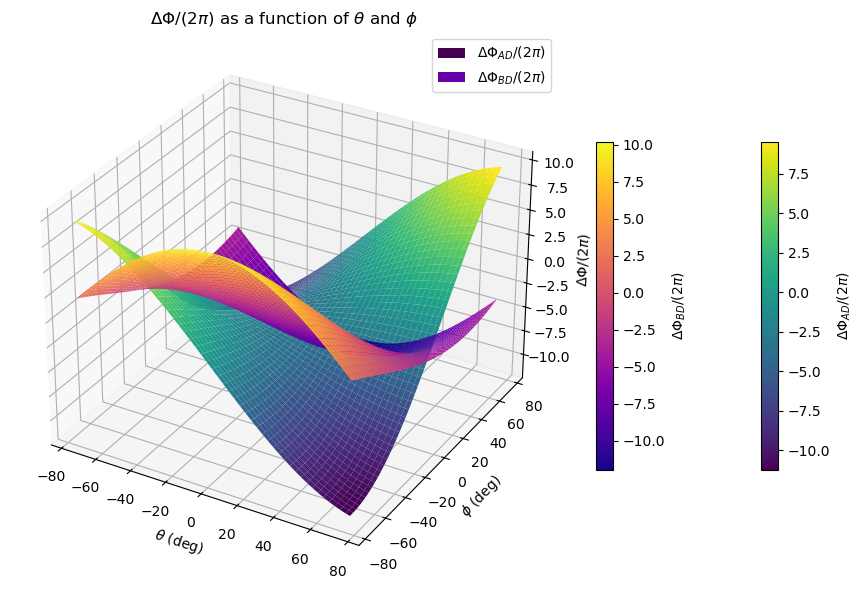

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Trying to find the range of delta r's 
lam = 3e8/24.15e9 

# Phi grid and theta grid with -pi/4 to pi/4 FoV 
Ph = np.linspace(-75*(np.pi/180), 75*(np.pi/180), 200)   # phi
Th = np.linspace(-75*(np.pi/180), 75*(np.pi/180), 200)   # theta

# Create 2D grid
TH, PH = np.meshgrid(Th, Ph)   # each is 100×100

# Convert spherical to Cartesian unit vector
# Using physics convention: 
# x = cos(theta)*sin(phi)
# y = sin(theta)*sin(phi)
# z = cos(phi)

x = np.cos(TH) * np.sin(PH)
y = np.sin(TH) * np.sin(PH)
z = np.cos(PH)

# Stack into (100,100,3)
d_hat = np.stack((x, y, z), axis=-1)

# Reshape into (100*100, 3)
d_hat_flat = d_hat.reshape(-1, 3)

a = np.array((0.0, 0.07, -0.020))    # face A (w.r.t. front-face origin) 
b = np.array((-0.072, 0.0, -0.02))     # face B

del_r_a = np.dot(d_hat_flat, a)                # Dot products
del_r_b = np.dot(d_hat_flat, b)

# Reshape del_r_a and del_r_b back to (100, 100) to match TH, PH
del_r_a_grid = del_r_a.reshape(PH.shape)   # or TH.shape (same)
del_r_b_grid = del_r_b.reshape(PH.shape)

# 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf_a = ax.plot_surface(TH*180/np.pi, PH*180/np.pi, (4*np.pi/lam)*del_r_a_grid / (2*np.pi), label=r'$\Delta \Phi_{AD}/(2\pi)$', cmap='viridis', edgecolor='none')
surf_b = ax.plot_surface(TH*180/np.pi, PH*180/np.pi, (4*np.pi/lam)*del_r_b_grid / (2*np.pi), label=r'$\Delta \Phi_{BD}/(2\pi)$', cmap='plasma', edgecolor='none')

fig.colorbar(surf_a, ax=ax, shrink=0.6, label=r'$\Delta \Phi_{AD}/(2\pi)$')
fig.colorbar(surf_b, ax=ax, shrink=0.6, label=r'$\Delta \Phi_{BD}/(2\pi)$')

ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$\phi$ (deg)')
ax.set_zlabel(r'$\Delta \Phi/(2\pi)$')
ax.set_title(r'$\Delta \Phi/(2\pi)$ as a function of $\theta$ and $\phi$')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing out the square case with a 125 mm × 125 mm starting offset

l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 
lam = 3e8/24.15e9
h = 0.075

# Scan sizing
N1 = 110
# N  = 110

#(meters)
x0 = 0.125  # 125 mm
y0 = 0.125  # 125 mm

# --- Segment length (meters) ---
seg = -0.125

# Generate the direction vector along radar direction
zr = 1.0

# First leg: along +x, y fixed at y0
xr1 = np.linspace(x0, x0 + seg, N1)
yr1 = np.full(N1, y0)
d1  = np.column_stack((xr1, yr1, np.full(N1, zr)))   # (N1, 3)
print(d1.shape)

# Second leg: along -y, x fixed at x0 + seg
yr2_full = np.linspace(y0, y0 + seg, N1)
yr2 = yr2_full
xr2 = np.full_like(yr2, x0 + seg)
d2  = np.column_stack((xr2, yr2, np.full_like(yr2, zr)))
print(d2.shape)

# Third leg: along -x, y fixed at y0 - seg
xr3_full = np.linspace(x0 + seg, x0 , N1)
xr3 = xr3_full
# xr3 = np.full_like(xr3, y0 - seg)
d3  = np.column_stack((xr3, np.full_like(xr3, yr2[-1]), np.full_like(xr3, zr)))
print(d3.shape)

# 4th leg: along +y, x fixed at x0 + seg
yr4_full = np.linspace(y0+seg, y0, N1)
yr4 = yr4_full
xr4 = np.full_like(yr4, xr3[-1])
d4  = np.column_stack((xr4, yr4, np.full_like(yr4, zr)))
print(d4.shape)

# Full path
d = np.vstack((d1, d2,d3, d4))
print(d.shape)

# Unit look vectors (tag origin -> radar)
norms = np.linalg.norm(d, axis=1)
d_hat = d / norms[:, np.newaxis]

# Face coordinates (meters) w.r.t. front-face origin
a = np.array((0.0,   0.045, -0.02))   # face A
b = np.array((-0.04, 0.0,   -0.02 ))   # face B
c = np.array((0.04, 0.0,   -0.02 ))

dr_a = -d_hat @ a
dr_b = -d_hat @ b
dr_c = -d_hat @ c
dphi_a = -(4*np.pi/lam) * dr_a
dphi_b = -(4*np.pi/lam) * dr_b
dphi_c = -(4*np.pi/lam) * dr_c

# # Build radar positions and normalize to unit look vectors
# norms = np.linalg.norm(d, axis=1)
# vhat = d / norms[:, None]             # tag-origin -> radar

# # SIGNED projections
# dr_a = vhat @ a
# dr_b = vhat @ b

# # Round-trip phase (still signed)
# dphi_a = (4*np.pi/lam) * dr_a
# dphi_b = (4*np.pi/lam) * dr_b

phaseAD = phaseA - phaseD
phaseBD = phaseB - phaseD
phaseCD = phaseC - phaseD

plt.plot(dphi_a, label="Phase A - D (calculated)")
plt.plot(dphi_b, label="Phase B - D (calculated)")
plt.plot(dphi_c, label="Phase C - D (calculated)")
plt.plot(phaseAD, label="Phase A - D (measured)")
plt.plot(phaseBD, label="Phase B - D (measured)")
plt.plot(phaseCD, label="Phase C - D (measured)")
plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]"); plt.tight_layout()

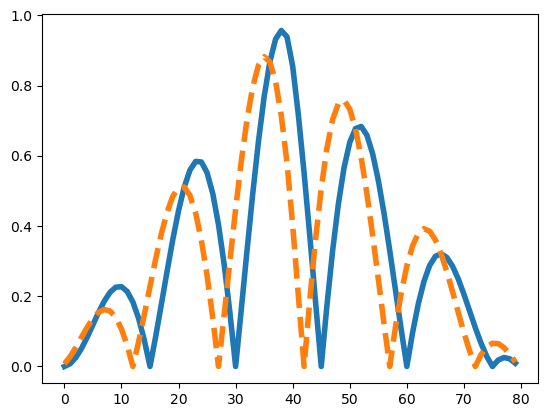

In [28]:
range_subset_width = 80 
n_frames = 1
period = 15
phiVal = np.pi/5
x = np.arange(0, range_subset_width) 
triWave = signal.windows.triang(range_subset_width)
sinW = np.abs(np.sin(x * np.pi / period))
sinW1 = np.abs(np.sin(x * np.pi / period + phiVal))
plt.plot(sinW*triWave, linewidth=4)
plt.plot(sinW1*triWave, linestyle='--', linewidth=4)
# plt.xlabel("Range Bin Subset")
# plt.ylabel(r"Phase ($\boldsymbol{I}$ component)")